In [9]:
%matplotlib inline

In [10]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import os
import os.path as osp

from tools.lib import makedirs, load_raw_data, load_raw_data_adv, get_all_results
from tools.functional import get_kappa_function
from configs import PATHS, ADV_PATHS, CLASS_NAMES

from embeddings import RegionEmbedding
from embeddings.utils import get_region_cos_mat, get_region_prob_mat
from embeddings.plot import ax_highlight_regions

**Setup dataset name, DNN architecture *etc.***

In [11]:
dataset = "TinyImagenet"
arch = "vgg16"
feature_layer = "conv_53"
adv_args = "pgd_inf_0.1_1_50_adv_all"
max_adv_iter = 20
result_folder = "./saved-results"
kappa_fn = get_kappa_function("./.cache/sample/kappa_max=10.0_dim=3.bin")

**Load some raw data**

In [12]:
images, logits_before = load_raw_data(
    PATHS=PATHS, dataset=dataset, arch=arch,
    data_names=["images", "logits"], device=torch.device("cpu")
)
logits_after, = load_raw_data_adv(ADV_PATHS, dataset, arch, adv_args, max_adv_iter, ["logits"], torch.device("cpu"))
images = images.numpy()
class_names = CLASS_NAMES[dataset]
sample_emb, sample_trans, class_direction, W_region, W_kernel, region_emb, region_trans = get_all_results(result_folder, dataset, arch, feature_layer="conv_53")
class_direction = torch.from_numpy(class_direction).float()
n_samples, n_regions = W_region.shape
width = int(np.sqrt(n_regions))
patch_width = int(224 / width)

**Load the transform $h^{(r)}=\Lambda f^{(r)}$**

In [13]:
transform = RegionEmbedding(in_dim=512, out_dim=3, device=torch.device("cpu"))
transform.load_state_dict(region_trans)

[RegionEmbedding] Finish initializing the transform.


<All keys matched successfully>

**Get regional embeddings before/after the attack based on the transformation above**

In [14]:
trajectory = []
trajectory_prob = []

for adv_iter in [0, 20]:
    print(f"iter {adv_iter}")
    regional_features, = load_raw_data_adv(
        ADV_PATHS, dataset, arch, adv_args, adv_iter,
        data_names=[f"{feature_layer}_features"], device=torch.device("cpu")
    )

    region_embs = transform.get_emb(regional_features).numpy()
    region_cos = get_region_cos_mat(region_embs=region_embs, class_direction=class_direction)
    region_prob = get_region_prob_mat(region_embs=region_embs, class_direction=class_direction, kappa_fn=kappa_fn)

    trajectory.append(region_embs.copy())
    trajectory_prob.append(region_prob.copy())

trajectory = np.stack(trajectory, axis=0)
trajectory_prob = np.stack(trajectory_prob, axis=0)

iter 0
iter 20


**Find the *knowledge points* before/after the adversarial attack**

In [15]:
threshold = 0.4
sample_ids = [24, 38, 58, 266, 461, 469, 488, 491, 496]
results = []

for sample_id in sample_ids:
    label_before_att = logits_before[sample_id].argmax()
    label_after_att = logits_after[sample_id].argmax()
    image = images[sample_id]
    trajectory_prob_sample = trajectory_prob[:, sample_id]

    regions_confident_after_attack = []
    for region_idx in range(n_regions):
        if trajectory_prob_sample[-1, region_idx, label_after_att] >= threshold:
            regions_confident_after_attack.append(region_idx)

    regions_confident_before_attack = []
    for region_idx in range(n_regions):
        if trajectory_prob_sample[0, region_idx, label_before_att] >= threshold:
            regions_confident_before_attack.append(region_idx)

    results.append([image, (regions_confident_before_attack, regions_confident_after_attack)])

**Visualize image regions corresponding to these *knowledge points***

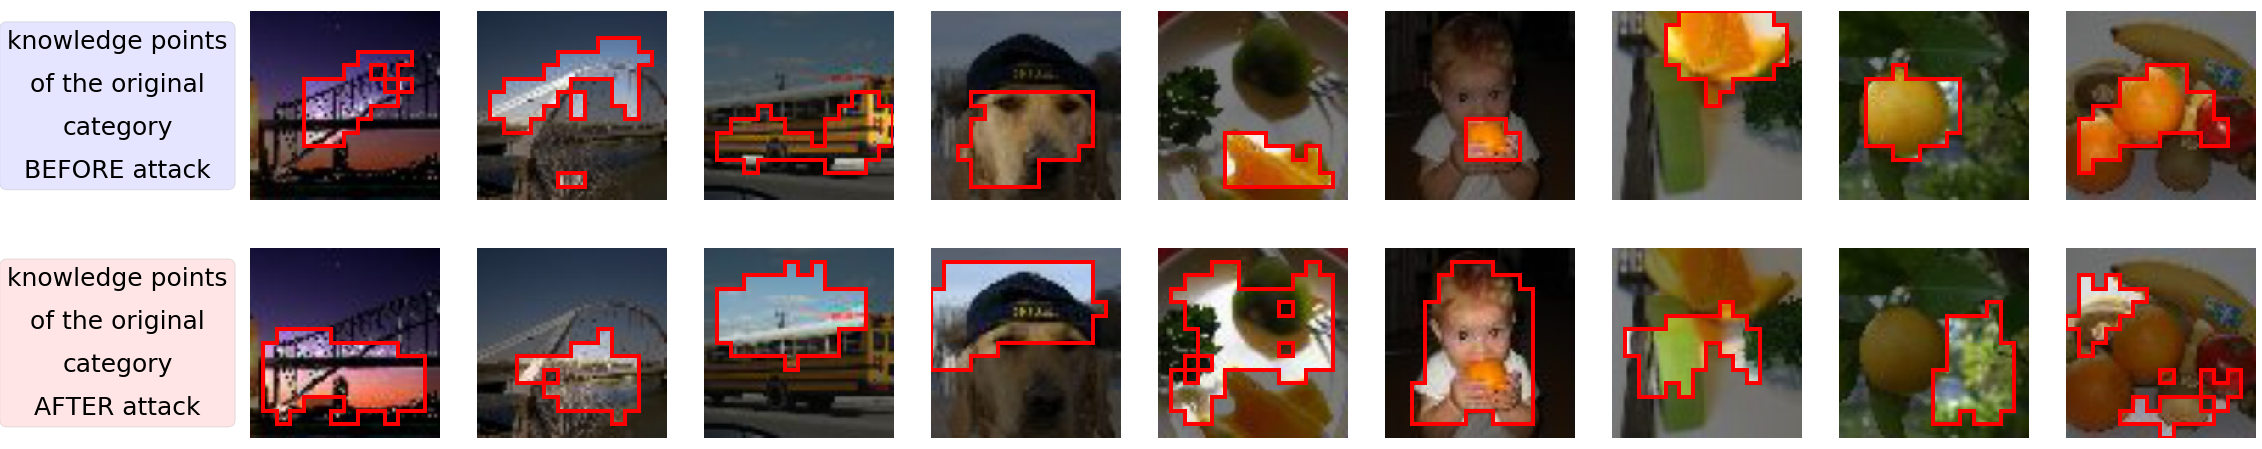

In [16]:
plt.figure(figsize=(4 * (1 + len(results)), 8))

for i, (image, (regions_before, regions_after)) in enumerate(results):
    ax = plt.subplot(2, len(results) + 1, i + 2)
    ax_highlight_regions(ax=ax, image=image, grid_width=patch_width, region_ids=regions_before)
    ax = plt.subplot(2, len(results) + 1, i + 3 + len(results))
    ax_highlight_regions(ax=ax, image=image, grid_width=patch_width, region_ids=regions_after)

ax = plt.subplot(2, len(results) + 1, 1)
textstr = "knowledge points\nof the original\ncategory\nBEFORE attack"
props = dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.1)
ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=25,
        linespacing=2.0, va='center', ha='center', bbox=props)
plt.axis("off")

ax = plt.subplot(2, len(results) + 1, len(results) + 2)
textstr = "knowledge points\nof the original\ncategory\nAFTER attack"
props = dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.1)
ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=25,
        linespacing=2.0, va='center', ha='center', bbox=props)
plt.axis("off")

plt.show()